In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

2024-04-22 19:04:46.676222: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 19:04:46.676348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 19:04:46.832857: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [3]:
data = tf.keras.utils.image_dataset_from_directory('/kaggle/input/image-classification-dataset/data')
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 1603 files belonging to 2 classes.


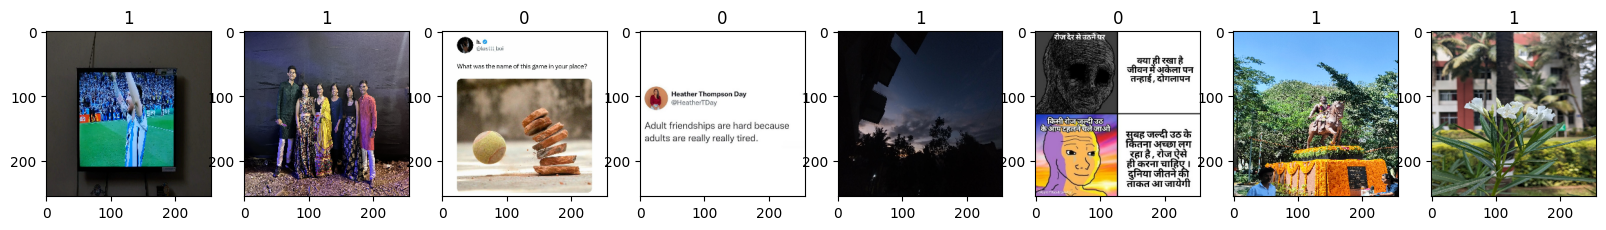

In [4]:
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [5]:
data = data.map(lambda x, y : (x / 255, y))

In [6]:
scaled_batch = data.as_numpy_iterator().next()

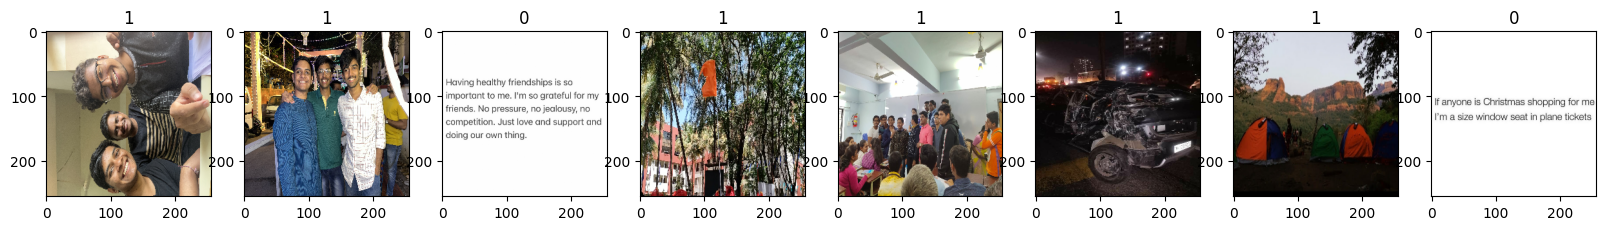

In [7]:
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx, img in enumerate(scaled_batch[0][:8]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(scaled_batch[1][idx])

In [8]:
len(data)

51

In [9]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = len(data) - (train_size + val_size)
print(train_size, val_size, test_size)

35 10 6


In [10]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [11]:
len(test)

6

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [13]:
model = Sequential()

In [14]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [15]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [17]:
logdir='/kaggle/working/logs'

In [18]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [19]:
hist = model.fit(train, epochs=30, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/30


I0000 00:00:1713812730.523963      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


35/35 [==============================] - 70s 2s/step - loss: 0.5752 - accuracy: 0.6911 - val_loss: 0.2011 - val_accuracy: 0.9125
Epoch 2/30
35/35 [==============================] - 61s 2s/step - loss: 0.1594 - accuracy: 0.9438 - val_loss: 0.1014 - val_accuracy: 0.9750
Epoch 3/30
35/35 [==============================] - 60s 2s/step - loss: 0.0767 - accuracy: 0.9750 - val_loss: 0.0981 - val_accuracy: 0.9688
Epoch 4/30
35/35 [==============================] - 59s 2s/step - loss: 0.0420 - accuracy: 0.9839 - val_loss: 0.0300 - val_accuracy: 0.9937
Epoch 5/30
35/35 [==============================] - 66s 2s/step - loss: 0.0253 - accuracy: 0.9929 - val_loss: 0.0238 - val_accuracy: 0.9969
Epoch 6/30
35/35 [==============================] - 60s 2s/step - loss: 0.0262 - accuracy: 0.9946 - val_loss: 0.0416 - val_accuracy: 0.9906
Epoch 7/30
35/35 [==============================] - 62s 2s/step - loss: 0.0139 - accuracy: 0.9955 - val_loss: 0.0141 - val_accuracy: 1.0000
Epoch 8/30
35/35 [=============

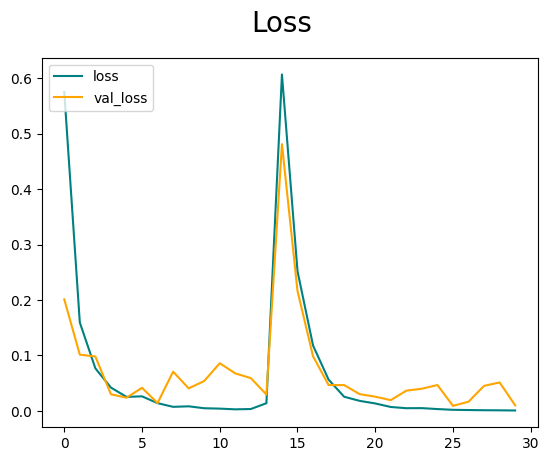

In [20]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

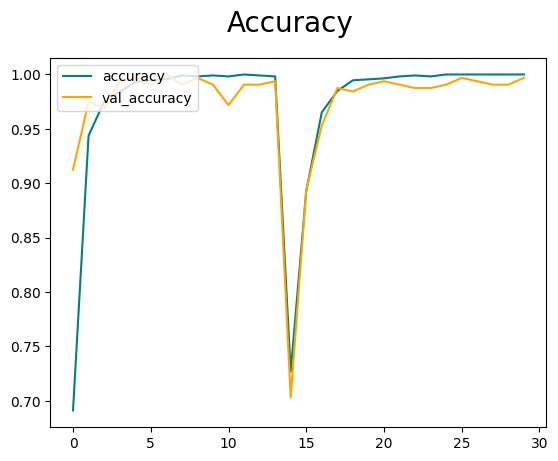

In [21]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [22]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
print(pre.result(), re.result(), acc.result())

1/1 [==============================] - 0s 320ms/step
tf.Tensor(0.97590363, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.9877301, shape=(), dtype=float32)


In [23]:
from tensorflow.keras.models import load_model

In [24]:
model.save(os.path.join('/kaggle/working/','new_imageclassifier.h5'))

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
